## Final Project
**Authors:** Nick Romano and Trevor McCormick   
**Version 1.12**   
**DS160-01: Introduction to Data Science**   


---

The datasets used in this notebook come from the Dodgers Loop Sensor Data Set from the UCI Machine Learning Repository.

**Citation:**    
Hutchins, J (2006). Dodgers Loop Sensor Data Set [Data set]. UCI Machine Learning Repository. Retrieved April 19, 2022, from [https://archive.ics.uci.edu/ml/datasets/dodgers+loop+sensor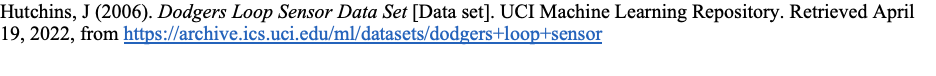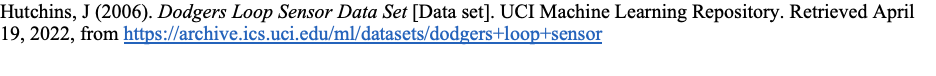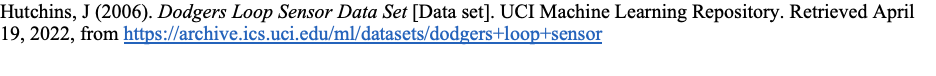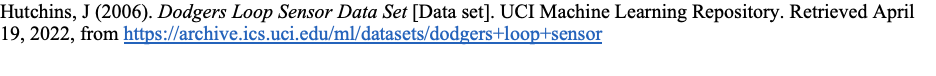]

Our goal is to be able to predict whether a Dodgers baseball game had ended given the flow of traffic measured by sensor data collected on the Glendale on ramp to 101 North Freeway, which is nearby Dodger Stadium.   

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#### Reading in Data

In [2]:
df_traffic = pd.read_csv("Dodgers.data", header = None)
df_games = pd.read_csv("Dodgers.events", header = None)

In [3]:
df_traffic

,0,1
0,4/10/2005 0:00,-1
1,4/10/2005 0:05,-1
2,4/10/2005 0:10,-1
3,4/10/2005 0:15,-1
4,4/10/2005 0:20,-1
...,...,...
50395,10/1/2005 23:35,-1
50396,10/1/2005 23:40,-1
50397,10/1/2005 23:45,-1
50398,10/1/2005 23:50,-1


In [4]:
df_games

,0,1,2,3,4,5
0,04/12/05,13:10:00,16:23:00,55892,San Francisco,W 9-8�
1,04/13/05,19:10:00,21:48:00,46514,San Francisco,W 4-1�
2,04/15/05,19:40:00,21:48:00,51816,San Diego,W 4-0�
3,04/16/05,19:10:00,21:52:00,54704,San Diego,W 8-3�
4,04/17/05,13:10:00,15:31:00,53402,San Diego,W 6-0�
...,...,...,...,...,...,...
76,09/25/05,13:10:00,16:06:00,37846,Pittsburgh,W 9-2�
77,09/26/05,19:10:00,22:27:00,36397,Pittsburgh,W 9-4�
78,09/27/05,19:10:00,21:33:00,42604,Arizona,L 2-0�
79,09/28/05,19:10:00,21:58:00,46424,Arizona,L 4-3�


In [5]:
df_traffic.to_csv("Original_Dodgers_Traffic.csv", index=False, header=False)

In [6]:
df_games.to_csv("Original_Dodgers_Events.csv", index=False, header=False)

We ended up saving an original version of the Dodgers.data and Dodgers.events data frames as .csv files to have a version in that format

---
#### Processesing and Cleaning up the data


**df_games cleanup**

In [7]:
df_games

,0,1,2,3,4,5
0,04/12/05,13:10:00,16:23:00,55892,San Francisco,W 9-8�
1,04/13/05,19:10:00,21:48:00,46514,San Francisco,W 4-1�
2,04/15/05,19:40:00,21:48:00,51816,San Diego,W 4-0�
3,04/16/05,19:10:00,21:52:00,54704,San Diego,W 8-3�
4,04/17/05,13:10:00,15:31:00,53402,San Diego,W 6-0�
...,...,...,...,...,...,...
76,09/25/05,13:10:00,16:06:00,37846,Pittsburgh,W 9-2�
77,09/26/05,19:10:00,22:27:00,36397,Pittsburgh,W 9-4�
78,09/27/05,19:10:00,21:33:00,42604,Arizona,L 2-0�
79,09/28/05,19:10:00,21:58:00,46424,Arizona,L 4-3�


Renaming the columns of df_games with appropriately labeled column names rather than leaving the the numbered column headings

In [8]:
df_games = df_games.rename(columns = {0: 'Date', 
                                      1: 'Starttime',
                                      2: 'Endtime',
                                      3: 'Total Attendance',
                                      4: 'Opponent',
                                      5: 'Result'})

df_games

,Date,Starttime,Endtime,Total Attendance,Opponent,Result
0,04/12/05,13:10:00,16:23:00,55892,San Francisco,W 9-8�
1,04/13/05,19:10:00,21:48:00,46514,San Francisco,W 4-1�
2,04/15/05,19:40:00,21:48:00,51816,San Diego,W 4-0�
3,04/16/05,19:10:00,21:52:00,54704,San Diego,W 8-3�
4,04/17/05,13:10:00,15:31:00,53402,San Diego,W 6-0�
...,...,...,...,...,...,...
76,09/25/05,13:10:00,16:06:00,37846,Pittsburgh,W 9-2�
77,09/26/05,19:10:00,22:27:00,36397,Pittsburgh,W 9-4�
78,09/27/05,19:10:00,21:33:00,42604,Arizona,L 2-0�
79,09/28/05,19:10:00,21:58:00,46424,Arizona,L 4-3�


Checking the data types of the df_games columns

In [9]:
df_games.dtypes

Date                object
Starttime           object
Endtime             object
Total Attendance     int64
Opponent            object
Result              object
dtype: object

Wanted to check whether or not there were null values in the dataframe before combining the Date and gametime columns

In [10]:
df_games.isna().sum()

Date                0
Starttime           0
Endtime             0
Total Attendance    0
Opponent            0
Result              0
dtype: int64

With the Date, Starttime, and Endtime taking up three columns we wanted to combine these columns in a way that would have just the Starttime and Endtime of each Dodgers game in Datetime form.   

Before doing so, we wanted to check whether or not there was a baseball game that extended into the next day. There doesn't seem to be a game that lasted into the next day as the latest Endtime value was 23:18:00 or 11:18:00 pm. Knowing this, we wouldn't have to perform any extra manipulations on the data in order change any of the values within the Date column to match the Endtime values.    

To combine the Date and Endtime columns, we converted these columns into strings and concatenated them with a space in between, then we converted that result into Datetime form and stored the value within the Endtime column. We did this same strategy with the Date and Startime columns and stored the resulting datetime value within the Date column. Then we dropped the Starttime column, since the needed data was now within the Date column, then renamed the Date column as Starttime 

In [11]:
print(max(df_games.Endtime))

23:18:00


In [12]:
df_games.Endtime = df_games.Date.astype(str) + " " + df_games.Endtime.astype(str)
df_games.Endtime = pd.to_datetime(df_games.Endtime)

df_games.Date = df_games.Date.astype(str) + " " + df_games.Starttime.astype(str)
df_games.Date = pd.to_datetime(df_games.Date)

df_games.drop(columns = ["Starttime", "Total Attendance", "Opponent", "Result"], inplace =True)
df_games.rename(columns = {'Date': 'Starttime'}, inplace=True)

In [13]:
df_games

,Starttime,Endtime
0,2005-04-12 13:10:00,2005-04-12 16:23:00
1,2005-04-13 19:10:00,2005-04-13 21:48:00
2,2005-04-15 19:40:00,2005-04-15 21:48:00
3,2005-04-16 19:10:00,2005-04-16 21:52:00
4,2005-04-17 13:10:00,2005-04-17 15:31:00
...,...,...
76,2005-09-25 13:10:00,2005-09-25 16:06:00
77,2005-09-26 19:10:00,2005-09-26 22:27:00
78,2005-09-27 19:10:00,2005-09-27 21:33:00
79,2005-09-28 19:10:00,2005-09-28 21:58:00


Checking if datetime conversion worked

In [14]:
df_games.dtypes

Starttime    datetime64[ns]
Endtime      datetime64[ns]
dtype: object

Saving cleaned df_games dataframe into a new csv file

In [15]:
df_games.to_csv("New_Dodgers_Events.csv", index=False)

**df_traffic clean up**

In [16]:
df_traffic

,0,1
0,4/10/2005 0:00,-1
1,4/10/2005 0:05,-1
2,4/10/2005 0:10,-1
3,4/10/2005 0:15,-1
4,4/10/2005 0:20,-1
...,...,...
50395,10/1/2005 23:35,-1
50396,10/1/2005 23:40,-1
50397,10/1/2005 23:45,-1
50398,10/1/2005 23:50,-1


Renaming the columns of df_traffic dataframe with appropriately labeled column names rather than leaving the the numbered column headings

In [17]:
df_traffic = df_traffic.rename(columns = {0: 'Date', 
                                          1: 'Traffic_flow'})

Wanted to check whether or not there were any NA or Null values within the Dataframe to see whether they would affect the conversion of the Date Column to Datetime

In [18]:
df_traffic.isna().sum()

Date            0
Traffic_flow    0
dtype: int64

The data within the Date column is represented as object rather than being in Datetime form

In [19]:
df_traffic.dtypes

Date            object
Traffic_flow     int64
dtype: object

In [20]:
df_traffic.Date = pd.to_datetime(df_traffic.Date)
df_traffic.dtypes

Date            datetime64[ns]
Traffic_flow             int64
dtype: object

Visualizing if datatype change happened correctly

In [21]:
df_traffic.sample(10)

,Date,Traffic_flow
41538,2005-09-01 05:30:00,10
14556,2005-05-30 13:00:00,18
5298,2005-04-28 09:30:00,30
23952,2005-07-02 04:00:00,5
14761,2005-05-31 06:05:00,19
8961,2005-05-11 02:45:00,3
44971,2005-09-13 03:35:00,-1
2356,2005-04-18 04:20:00,1
37869,2005-08-19 11:45:00,28
8419,2005-05-09 05:35:00,7


Since we are trying to predict whether or not a Dodgers baseball game had just ended given the traffic car count, we wanted to add a column to the df_traffic dataframe that has a 1 indicating the times around the ending of a Dodgers game and 0 otherwise. In determining the end of a baseball game based on the traffic, we decided to create a window of time just before the end and after the end of a baseball game since some people tend to leave just before the end of the game and that traffic builds up after the game since everyone is leaving. 

The occurance list stores the index values within the df_traffic dataframe that are within 30 minutes before the ending of each baseball game and 60 minutes after the ending time for each baseball game that was listed within the df_games dataframe. We added a "Game_Ended" column to the dataframe with an initial value of 0 and added 1 to any index value that is in the occurance list. So, 1 represents that Dodgers Game within a 90 minute window of the actual ending time and 0 indicates that a Dodgers game hadn't ended.

Looking ahead, we thought that we might want to take into account the weekday, hour, and minute in building our models so we pulled the these datapoints from the Date column and stored each of them into their own column.

Note: We previously tried to run the following code to for pulling the indexes of the df_traffic.Date that fall within a time window of the df_games.Endtime data.   
**for i in occurance_list:   
    for j in df_traffic.index.values:   
        if j == i:   
            df_traffic.Game_Ended[i] += 1**

However, we got a SettingWithCopyingWarning. To get around this, we used .iat[i] to get access to the data at a specific value that is at a specific index value since we were looping through the index values

In [22]:
df_traffic.insert(1, "Day_of_Week", 0)
df_traffic.insert(2, "Hour", 0)
df_traffic.insert(3, "Minute", 0)
df_traffic.insert(5, "Game_Ended", 0)

In [23]:
print(df_games.Endtime.index.values)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80]


In [24]:
occurance_list = []
for i in range(0, 81):
    a = df_traffic[(df_traffic.Date >= (df_games.Endtime[i] - pd.Timedelta(minutes = 30))) & 
                   (df_traffic.Date <= (df_games.Endtime[i] + pd.Timedelta(hours = 1)))].index.values.tolist()
    for j in a:
        occurance_list.append(j)

for i in occurance_list:
    for j in df_traffic.index.values:
        if j == i:
            df_traffic.Game_Ended.iat[i] += 1

In [25]:
for i in df_traffic.index.values:
    df_traffic.Day_of_Week.iat[i] = df_traffic.Date.iat[i].weekday()
    df_traffic.Hour.iat[i] = df_traffic.Date.iat[i].hour
    df_traffic.Minute.iat[i] = df_traffic.Date.iat[i].minute

Using a Query to check the output previous few cells

In [26]:
df_traffic.query("Game_Ended == 1").sample(15)

,Date,Day_of_Week,Hour,Minute,Traffic_flow,Game_Ended
7172,2005-05-04 21:40:00,2,21,40,26,1
15242,2005-06-01 22:10:00,2,22,10,41,1
49807,2005-09-29 22:35:00,3,22,35,44,1
24108,2005-07-02 17:00:00,5,17,0,39,1
31574,2005-07-28 15:10:00,3,15,10,56,1
35114,2005-08-09 22:10:00,1,22,10,16,1
49803,2005-09-29 22:15:00,3,22,15,31,1
28125,2005-07-16 15:45:00,5,15,45,34,1
40296,2005-08-27 22:00:00,5,22,0,55,1
28141,2005-07-16 17:05:00,5,17,5,58,1


**Dropping missing values**

The Dodgers.name file mentions that the missing values that are within the Traffic_flow column are indicated with a value of -1.   
   
By using a query to look up the number of times that the Traffic_flow is equal to -1, we see thatthere are 2903 instances of -1. This means that there are a total of **2903** of missing values within the df_traffic dataframe, **54** of which occur around the time that a Dodgers game had ended. The total 2903 missing values within the df_traffic dataframe represents roughly **5.76%** of the total data points. The 122 missing data points that occur around the ending of a Dodgers games represents just a shade over **3.678%** of the data points that occur around the ending a Dodgers game. 

In [27]:
print(f"Total number of missing values: {df_traffic.query('Traffic_flow == -1').Traffic_flow.count()}")
print(f"Proportion of the total number of missing values: {(df_traffic.query('Traffic_flow == -1').Traffic_flow.count() / df_traffic.Traffic_flow.count()) * 100}%")

Total number of missing values: 2903
Proportion of the total number of missing values: 5.759920634920635%


In [28]:
print(f"Total number of missing values that occur around the end of a Dodgers game: {df_traffic.query('Traffic_flow == -1 and Game_Ended == 1').Traffic_flow.count()}")
print(f"Proportion of the total of missing values that occur around the end of a Dodgers game: {(df_traffic.query('Traffic_flow == -1 and Game_Ended == 1').Traffic_flow.count() / df_traffic.query('Game_Ended == 1').Traffic_flow.count()) * 100}%")


Total number of missing values that occur around the end of a Dodgers game: 54
Proportion of the total of missing values that occur around the end of a Dodgers game: 3.6784741144414173%


   
Futhermore, it doesn't appear that we are missing to much data from the games since we are only missing traffic data that only happen after a total of 3 games

In [29]:
df_traffic.query('Traffic_flow == -1 and Game_Ended == 1').Date.dt.date.groupby(
    df_traffic.query('Traffic_flow == -1 and Game_Ended == 1').Date.dt.date).count()

Date
2005-06-27    18
2005-06-28    18
2005-09-10    18
Name: Date, dtype: int64

Since the missing data represents just a small portion of the data that does and doesn;t occur around the ending of a baseball game, we decided to drop the 2903 values

In [30]:
df_traffic = df_traffic[df_traffic.Traffic_flow != -1]
df_traffic.reset_index(drop = True, inplace=True)
df_traffic

,Date,Day_of_Week,Hour,Minute,Traffic_flow,Game_Ended
0,2005-04-11 07:35:00,0,7,35,23,0
1,2005-04-11 07:40:00,0,7,40,42,0
2,2005-04-11 07:45:00,0,7,45,37,0
3,2005-04-11 07:50:00,0,7,50,24,0
4,2005-04-11 07:55:00,0,7,55,39,0
...,...,...,...,...,...,...
47492,2005-09-30 23:45:00,4,23,45,14,0
47493,2005-09-30 23:50:00,4,23,50,12,0
47494,2005-09-30 23:55:00,4,23,55,8,0
47495,2005-10-01 00:00:00,5,0,0,13,0


With pulling out the day of week, hour and minute from the Date column into their own columns we ended up dropping the Date Column

In [31]:
df_traffic.drop(["Date"], axis=1, inplace=True)

Even with the message, the dataframe still dropped the Date column

In [32]:
df_traffic

,Day_of_Week,Hour,Minute,Traffic_flow,Game_Ended
0,0,7,35,23,0
1,0,7,40,42,0
2,0,7,45,37,0
3,0,7,50,24,0
4,0,7,55,39,0
...,...,...,...,...,...
47492,4,23,45,14,0
47493,4,23,50,12,0
47494,4,23,55,8,0
47495,5,0,0,13,0


In [33]:
df_traffic.to_csv("New_Dodgers_Traffic.csv", index=False)

### Description of Cleaned Traffic Dataset

**Basic Summary of Dataset**

In [34]:
df_traffic.shape

(47497, 5)

In [35]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47497 entries, 0 to 47496
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Day_of_Week   47497 non-null  int64
 1   Hour          47497 non-null  int64
 2   Minute        47497 non-null  int64
 3   Traffic_flow  47497 non-null  int64
 4   Game_Ended    47497 non-null  int64
dtypes: int64(5)
memory usage: 1.8 MB


**Unusual Inbalance between datapoints that occur during non-ending game intervals and game ending intervals**

In [36]:
Values = pd.DataFrame({"Value Count": df_traffic.Game_Ended.value_counts()})
Values.rename(index = {0: "Otherwise",
                       1: "Around the End of a Dodgers Game"}, inplace = True)

Values

,Value Count
Otherwise,46083
Around the End of a Dodgers Game,1414


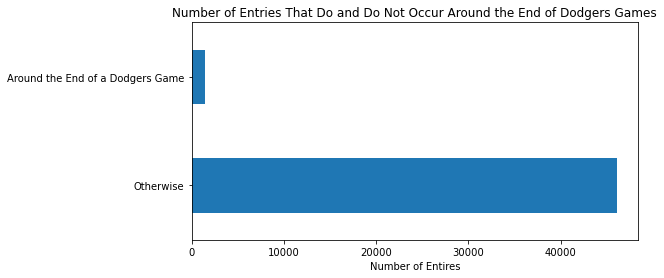

In [37]:
figure = plt.figure(figsize = (8,4))
Values["Value Count"].plot(kind="barh")
plt.title("Number of Entries That Do and Do Not Occur Around the End of Dodgers Games")
plt.xlabel("Number of Entires")
plt.savefig('Inbalanced_barchart.png', bbox_inches='tight')

### Creating a balanced dataset

Due to this drastic difference in the number of entries that occur around when a Dodgers game ended and when a Dodgers game had not ended, we resampled the Traffic dataset to include a total of 1414 data points of Traffic for when a Dodgers game had not ended, in order to balance out the Dataset. 

In [38]:
Game_Ended = df_traffic.query("Game_Ended == 1")
No_Game_Ending = df_traffic.query("Game_Ended == 0")
No_Game_Ending_resampled = resample(No_Game_Ending, n_samples = 1414)
balanced_traffic = pd.concat([Game_Ended, No_Game_Ending_resampled], axis = 0)
balanced_traffic.reset_index(drop = True, inplace=True)
balanced_traffic

balanced_traffic.to_csv("Balanced_New_Dodgers_Traffic.csv", index=False)

In [39]:
balanced_traffic

,Day_of_Week,Hour,Minute,Traffic_flow,Game_Ended
0,1,15,55,38,1
1,1,16,0,57,1
2,1,16,5,58,1
3,1,16,10,51,1
4,1,16,15,55,1
...,...,...,...,...,...
2823,2,18,35,26,0
2824,2,15,10,40,0
2825,0,11,45,28,0
2826,4,16,5,24,0


### Dataset Descriprion of Balanced Dataset

**Basic Summary of Dataset**

In [40]:
balanced_traffic.shape

(2828, 5)

In [41]:
balanced_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2828 entries, 0 to 2827
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Day_of_Week   2828 non-null   int64
 1   Hour          2828 non-null   int64
 2   Minute        2828 non-null   int64
 3   Traffic_flow  2828 non-null   int64
 4   Game_Ended    2828 non-null   int64
dtypes: int64(5)
memory usage: 110.6 KB


**Interesting Statistics**

Comparing the distributions of the car counts of the balanced dataset, the car count or traffic distribution around the time Dodgers games ends sees a higher frequency of higher car counts compared to non Dodgers game ending intervals

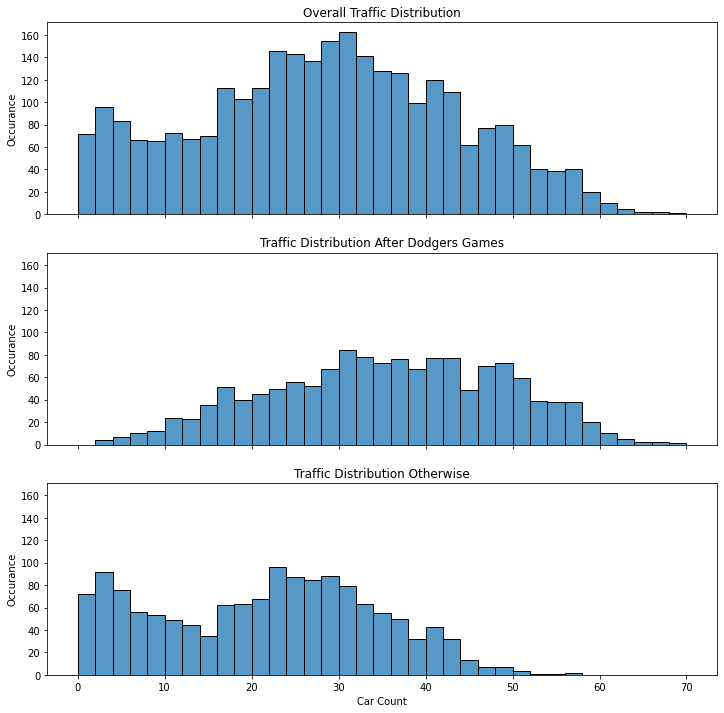

In [42]:
figure1, axes = plt.subplots(3,1, figsize=(12,12), sharex=True, sharey= True)
sns.histplot(data=balanced_traffic, x="Traffic_flow", binwidth = 2, ax=axes[0]).set(title = "Overall Traffic Distribution", 
                                                                      xlabel = "Car Count",
                                                                      ylabel = "Occurance")

sns.histplot(data=balanced_traffic.query("Game_Ended == 1"), x="Traffic_flow", binwidth = 2, ax=axes[1]).set(
    title = "Traffic Distribution After Dodgers Games", 
    xlabel = "Car Count",
    ylabel = "Occurance")

sns.histplot(data=balanced_traffic.query("Game_Ended == 0"), x="Traffic_flow", binwidth = 2, ax=axes[2]).set(
    title = "Traffic Distribution Otherwise", 
    xlabel = "Car Count",
    ylabel = "Occurance")

plt.savefig('Traffic_Count_Distributions.png', bbox_inches='tight')

Wanting to see how Dodgers the ending games affects the total car by time, we created a bar chart containing the number of 5-minute intervals around the ending of a Dodgers and a heatmap heatmap for the total car count by minute (x-axis) and hour (y-axis). In doing so we see that the total car count increases around the time that a Dodgers game ends

In [43]:
#Heat map preperations
traffic_table = pd.DataFrame(balanced_traffic.Traffic_flow.groupby([balanced_traffic.Hour,balanced_traffic.Minute]).sum())
traffic_table.rename_axis(["hour", "minute"], inplace=True)
traffic_table = traffic_table.reset_index()
traffic_table = traffic_table.pivot("hour", "minute", "Traffic_flow")

In [44]:
Game_ending_hours = balanced_traffic.query("Game_Ended == 1").Hour.groupby(balanced_traffic.query("Game_Ended == 1").Hour).count()

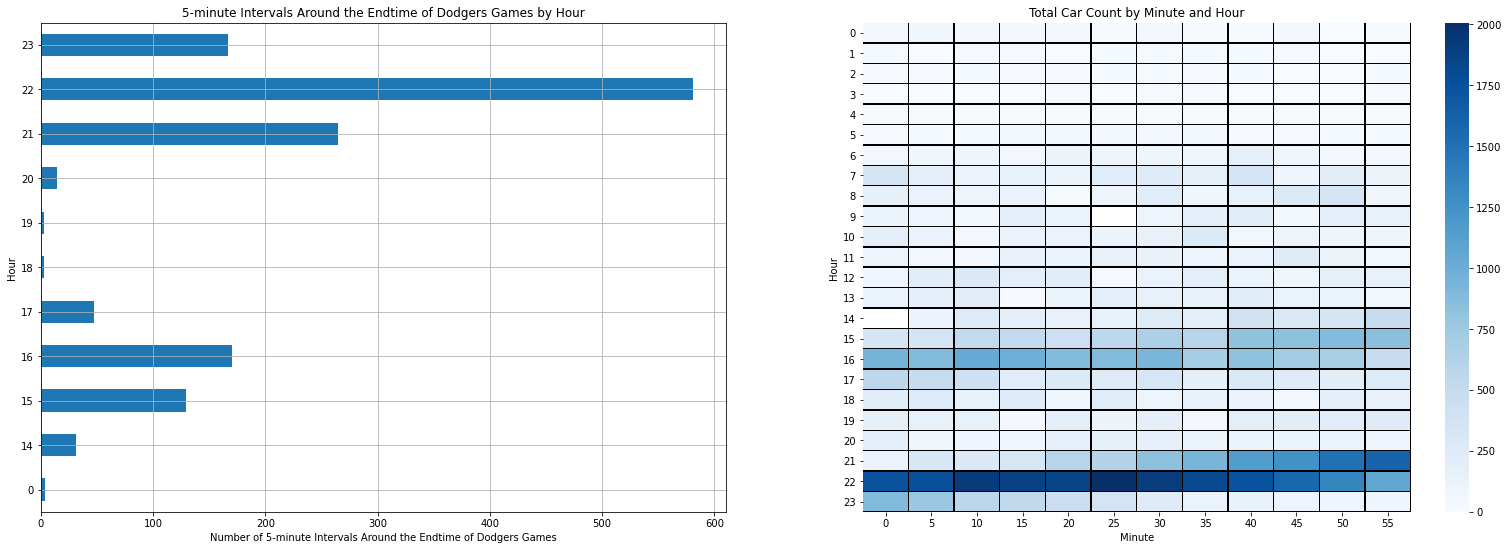

In [45]:
figure2 = plt.figure(figsize=(27,9))

ax1 = figure2.add_subplot(121)
Game_ending_hours.plot(kind="barh", grid=True)
plt.title("5-minute Intervals Around the Endtime of Dodgers Games by Hour")
plt.ylabel("Hour")
plt.xlabel("Number of 5-minute Intervals Around the Endtime of Dodgers Games")

ax2 = figure2.add_subplot(122)
sns.heatmap(traffic_table, cmap='Blues', linewidths=.5, linecolor='black')
plt.title("Total Car Count by Minute and Hour")
plt.ylabel("Hour")
plt.xlabel("Minute")
plt.yticks(rotation=0)

plt.savefig('Game_Ending_Intervals_and_Total_Traffic_Count.png', bbox_inches='tight')

### Final Processesing Before Working on Models

**One Hot Encoding The Categorical Weekday, Hour, and Minute Columns**

In [46]:
encoder = OneHotEncoder(handle_unknown='ignore')

In an attempt to come up with a one hot encoding function, we used the One Hot Encoder documentation <a href="https://scikit-learn.org/0.24/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=one%20hot%20encoding?">page</a> on the Scikit Learn documentation website to help with the function.  

Note: We were having trouble with how the column headers were being stored (see commented out cell). We initially didn't account for the columns being stored as MultiIndexes, where each column value was a tuple. So we had to use the line `encoded_column_df.columns.get_level_values()` to help get the column headers the way that we wanted them formatted. We used one of the documentation <a href="https://pandas.pydata.org/pandas-docs/version/1.2/user_guide/advanced.html?">pages</a> on the pandas documentation website for some help with the MultiIndex problem

In [50]:
#column_data = np.array(balanced_traffic.Day_of_Week).reshape(-1, 1)
#column_data = encoder.fit_transform(column_data).toarray()
#encoded_column_df = pd.DataFrame(column_data, columns=encoder.categories_)
#print(encoded_column_df.columns)

MultiIndex([(0,),
            (1,),
            (2,),
            (3,),
            (4,),
            (5,),
            (6,)],
           )


In [51]:
def one_hot_encoding_data(column_name):
    column_data = np.array(column_name).reshape(-1, 1)
    column_data = encoder.fit_transform(column_data).toarray()
    encoded_column_df = pd.DataFrame(column_data, columns=encoder.categories_)
    encoded_column_df.columns = encoded_column_df.columns.get_level_values(0)
    return encoded_column_df

*Passing the individual balanced_traffic columns through the one_hot_encoding_data and renaming the columns of the resulting dataframe to an appropriate column header*

In [52]:
day_of_week_encoded = one_hot_encoding_data(balanced_traffic.Day_of_Week)
day_of_week_encoded.rename(columns={0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}, inplace=True)


*Dropping the Day_of_Week column from the balanced traffic dataframe, so that we can concatenate the day_of_week_encoded dataframe with what remains in the balanced_traffic dataframe*


In [53]:
balanced_traffic.drop(["Day_of_Week"], axis=1, inplace=True)
encoded_balanced_traffic = pd.concat([day_of_week_encoded, balanced_traffic], axis=1)

In [54]:
encoded_balanced_traffic

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Hour,Minute,Traffic_flow,Game_Ended
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15,55,38,1
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16,0,57,1
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16,5,58,1
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16,10,51,1
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16,15,55,1
...,...,...,...,...,...,...,...,...,...,...,...
2823,0.0,0.0,1.0,0.0,0.0,0.0,0.0,18,35,26,0
2824,0.0,0.0,1.0,0.0,0.0,0.0,0.0,15,10,40,0
2825,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11,45,28,0
2826,0.0,0.0,0.0,0.0,1.0,0.0,0.0,16,5,24,0


In [55]:
encoded_balanced_traffic.to_csv("encoded_balanced_traffic.csv", index = False)

### Models

In [56]:
def Confusion_matrix_graph(y_testing_data, y_prediction_data, filename):
    matrix = confusion_matrix(y_true = y_testing_data, y_pred = y_prediction_data)
    figure = plt.figure(figsize=(8,8))
    heatmap = sns.heatmap(matrix, annot=True, fmt = ".2f", cmap = "RdYlGn")
    plt.ylabel("Correct Value")
    plt.xlabel("Predicted Value")
    plt.title("Confusion Matrix")
    plt.savefig(filename)

In [57]:
y = encoded_balanced_traffic.Game_Ended

In [60]:
X = np.array(encoded_balanced_traffic.iloc[:, :-1])
X

array([[ 0.,  1.,  0., ..., 15., 55., 38.],
       [ 0.,  1.,  0., ..., 16.,  0., 57.],
       [ 0.,  1.,  0., ..., 16.,  5., 58.],
       ...,
       [ 1.,  0.,  0., ..., 11., 45., 28.],
       [ 0.,  0.,  0., ..., 16.,  5., 24.],
       [ 0.,  0.,  0., ..., 16., 45., 21.]])

**Logistic Regression**

*Experiment Parameter 1*

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.80,
                                                    test_size=.20, 
                                                    random_state=25)

model = LogisticRegression(max_iter = 250).fit(X_train, y_train)

In [196]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,

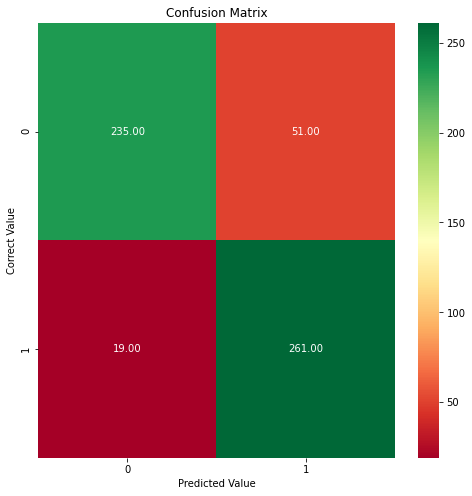

In [197]:
Confusion_matrix_graph(y_test, y_pred, "logistic_reg_confusion_matrix1.png")

In [198]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       286
           1       0.84      0.93      0.88       280

    accuracy                           0.88       566
   macro avg       0.88      0.88      0.88       566
weighted avg       0.88      0.88      0.88       566



*Experiment Parameter 2*

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.70,
                                                    test_size=.30, 
                                                    random_state=25)

model = LogisticRegression(max_iter = 250).fit(X_train, y_train)

In [200]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,

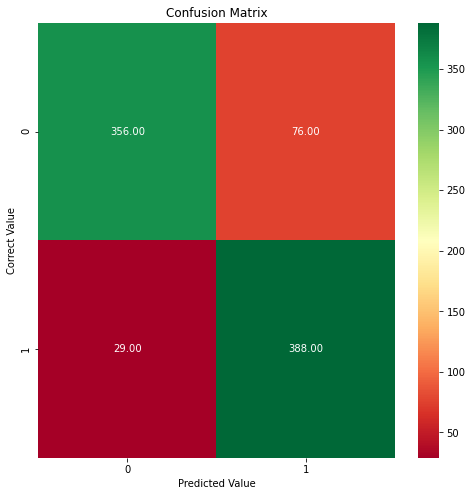

In [201]:
Confusion_matrix_graph(y_test, y_pred, "logistic_reg_confusion_matrix2.png")

In [202]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       432
           1       0.84      0.93      0.88       417

    accuracy                           0.88       849
   macro avg       0.88      0.88      0.88       849
weighted avg       0.88      0.88      0.88       849



*Experiment Parameter 3*

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.75,
                                                    test_size=.25, 
                                                    random_state=25)

model = LogisticRegression(max_iter = 250).fit(X_train, y_train)
model

LogisticRegression(max_iter=250)

In [204]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,

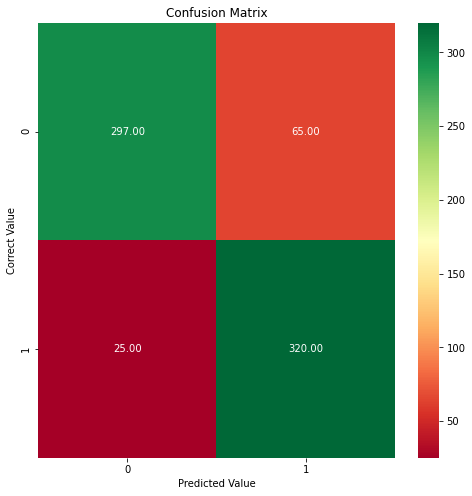

In [205]:
Confusion_matrix_graph(y_test, y_pred, "logistic_reg_confusion_matrix3.png")

In [206]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       362
           1       0.83      0.93      0.88       345

    accuracy                           0.87       707
   macro avg       0.88      0.87      0.87       707
weighted avg       0.88      0.87      0.87       707



**Random Forest**

*Experiment Parameter 1*

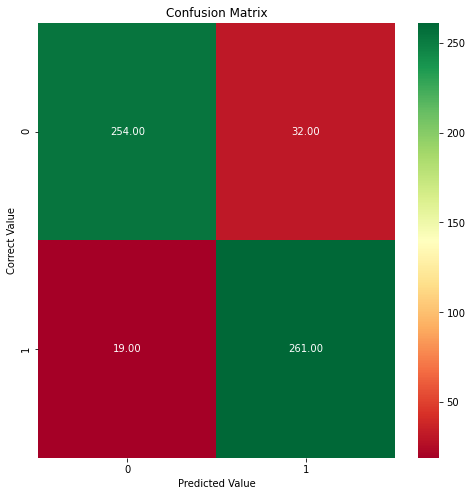

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.80,
                                                    test_size=.20, 
                                                    random_state=25)
model = RandomForestClassifier(n_estimators = 100,
                               criterion = "entropy", 
                               bootstrap = False)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
Confusion_matrix_graph(y_test, y_pred, "Random_Forest_confusion_matrix1.png")

In [208]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       286
           1       0.89      0.93      0.91       280

    accuracy                           0.91       566
   macro avg       0.91      0.91      0.91       566
weighted avg       0.91      0.91      0.91       566



*Experiment Parameter 2*

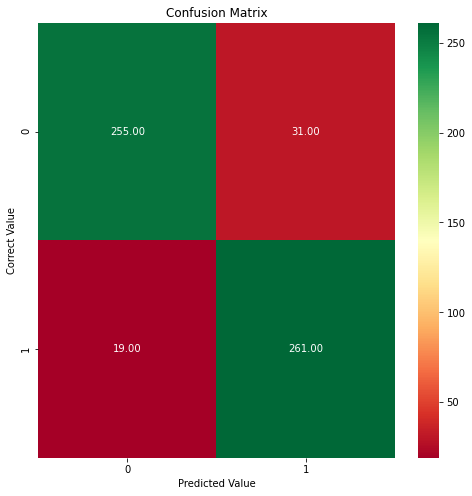

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.80,
                                                    test_size=.20, 
                                                    random_state=25)

model = RandomForestClassifier(n_estimators = 750,
                               criterion = "entropy", 
                               bootstrap = False)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
Confusion_matrix_graph(y_test, y_pred, "Random_Forest_confusion_matrix2.png")

In [210]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       286
           1       0.89      0.93      0.91       280

    accuracy                           0.91       566
   macro avg       0.91      0.91      0.91       566
weighted avg       0.91      0.91      0.91       566



*Experiment Parameter 3*

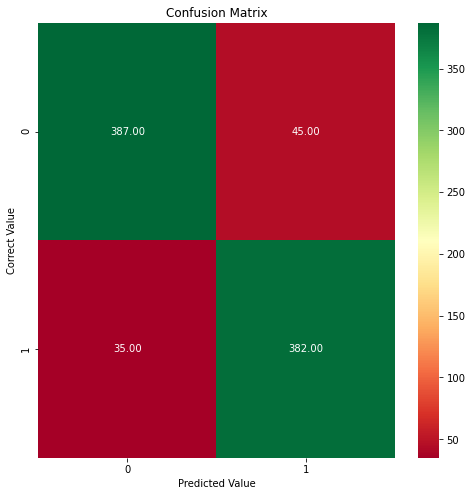

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.70,
                                                    test_size=.30, 
                                                    random_state=25)

model = RandomForestClassifier(n_estimators = 100,
                               criterion = "entropy",
                               bootstrap = False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
Confusion_matrix_graph(y_test, y_pred, "Random_Forest_confusion_matrix3.png")

In [212]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       432
           1       0.89      0.92      0.91       417

    accuracy                           0.91       849
   macro avg       0.91      0.91      0.91       849
weighted avg       0.91      0.91      0.91       849



*Experiment Parameter 4*

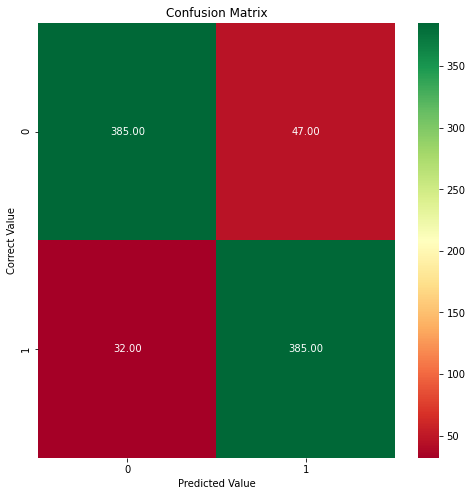

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.70,
                                                    test_size=.30, 
                                                    random_state=25)

model = RandomForestClassifier(n_estimators = 750,
                               criterion = "entropy",
                               bootstrap = False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
Confusion_matrix_graph(y_test, y_pred, "Random_Forest_confusion_matrix4.png")

In [214]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       432
           1       0.89      0.92      0.91       417

    accuracy                           0.91       849
   macro avg       0.91      0.91      0.91       849
weighted avg       0.91      0.91      0.91       849

